<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/Dec21_ge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import kagglehub

# Setup Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Constants
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16  # Reduced batch size for safety
LEARNING_RATE = 0.001

# Download Data
dataset_path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")
dataset_path = f'{dataset_path}/celeba_hq_256'
print(f"Dataset path: {dataset_path}")

Using device: cuda
Using Colab cache for faster access to the 'celebahq-resized-256x256' dataset.
Dataset path: /kaggle/input/celebahq-resized-256x256/celeba_hq_256


In [11]:
class InpaintingDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def create_mask(self):
        # Create a mask with a random rectangular hole
        mask = torch.ones((1, IMG_HEIGHT, IMG_WIDTH))
        h_hole, w_hole = IMG_HEIGHT // 3, IMG_WIDTH // 3

        y1 = random.randint(0, IMG_HEIGHT - h_hole)
        x1 = random.randint(0, IMG_WIDTH - w_hole)

        mask[:, y1:y1+h_hole, x1:x1+w_hole] = 0
        return mask

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        mask = self.create_mask()
        masked_img = img * mask

        return masked_img, mask, img

    def __len__(self):
        return len(self.image_paths)

In [12]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import kagglehub

# --- 1. CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 256
BATCH_SIZE = 16

# Standard ImageNet Mean/Std (Critical for pre-trained models)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# --- 2. PRE-PROCESSING ---

def get_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD) # Centers data for better learning
    ])

def denormalize(tensor):
    """Reverses the ImageNet normalization for visualization"""
    # Clone to avoid modifying original tensor
    t = tensor.clone().detach().cpu()

    # Create the denormalization transform
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(MEAN, STD)],
        std=[1/s for s in STD]
    )

    t = inv_normalize(t)
    t = torch.clamp(t, 0, 1) # Ensure valid pixel range
    return t

class ImprovedInpaintingDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def create_mask(self):
        # Improved masking: mix of sizes to prevent overfitting to one hole size
        mask = torch.ones((1, IMG_SIZE, IMG_SIZE))

        # Random hole size between 1/4 and 1/2 of image
        h_hole = random.randint(IMG_SIZE // 4, IMG_SIZE // 2)
        w_hole = random.randint(IMG_SIZE // 4, IMG_SIZE // 2)

        y1 = random.randint(0, IMG_SIZE - h_hole)
        x1 = random.randint(0, IMG_SIZE - w_hole)

        mask[:, y1:y1+h_hole, x1:x1+w_hole] = 0
        return mask

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            img = Image.open(img_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            mask = self.create_mask()
            # Apply mask (0 inside hole, 1 outside)
            masked_img = img * mask

            return masked_img, mask, img
        except Exception as e:
            # Skip corrupted images
            return self.__getitem__(random.randint(0, len(self.image_paths)-1))

    def __len__(self):
        return len(self.image_paths)

# --- 3. HIGH-RES VISUALIZATION ---

def visualize_1080p(model, loader, device):
    """Generates a 1920x1080 resolution comparison plot"""
    model.eval()
    masked_img, mask, ground_truth = next(iter(loader))
    masked_img, mask, ground_truth = masked_img.to(device), mask.to(device), ground_truth.to(device)

    with torch.no_grad():
        prediction = model(masked_img, mask)

    # Take first 4 items from batch
    n_samples = 4

    # Setup 1080p Figure (19.2 x 10.8 inches at 100 DPI = 1920x1080)
    fig, axes = plt.subplots(n_samples, 3, figsize=(19.2, 10.8), dpi=100)
    fig.patch.set_facecolor('#1e1e1e') # Dark mode background

    titles = ['Input (Masked)', 'Model Output', 'Ground Truth']

    for i in range(n_samples):
        # Denormalize images for plotting
        imgs = [
            denormalize(masked_img[i]),
            denormalize(prediction[i]),
            denormalize(ground_truth[i])
        ]

        for j, img_tensor in enumerate(imgs):
            ax = axes[i, j]
            # Convert (C, H, W) -> (H, W, C)
            img_np = img_tensor.permute(1, 2, 0).numpy()
            ax.imshow(img_np)

            # Styling
            if i == 0:
                ax.set_title(titles[j], color='white', fontsize=16, pad=20)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- SETUP DATA LOADERS ---
# (Assuming dataset_path is already defined from your code)
dataset_path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")
dataset_path = f'{dataset_path}/celeba_hq_256'
image_paths = glob.glob(f'{dataset_path}/*.jpg')
train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)

train_loader = DataLoader(ImprovedInpaintingDataset(train_paths, get_transforms()),
                         batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ImprovedInpaintingDataset(test_paths, get_transforms()),
                        batch_size=BATCH_SIZE, shuffle=False)

Using Colab cache for faster access to the 'celebahq-resized-256x256' dataset.


Initializing ResNet-UNet...


Epoch 1/5: 100%|██████████| 1688/1688 [11:12<00:00,  2.51it/s, loss=0.968]


Visualizing Epoch 1...


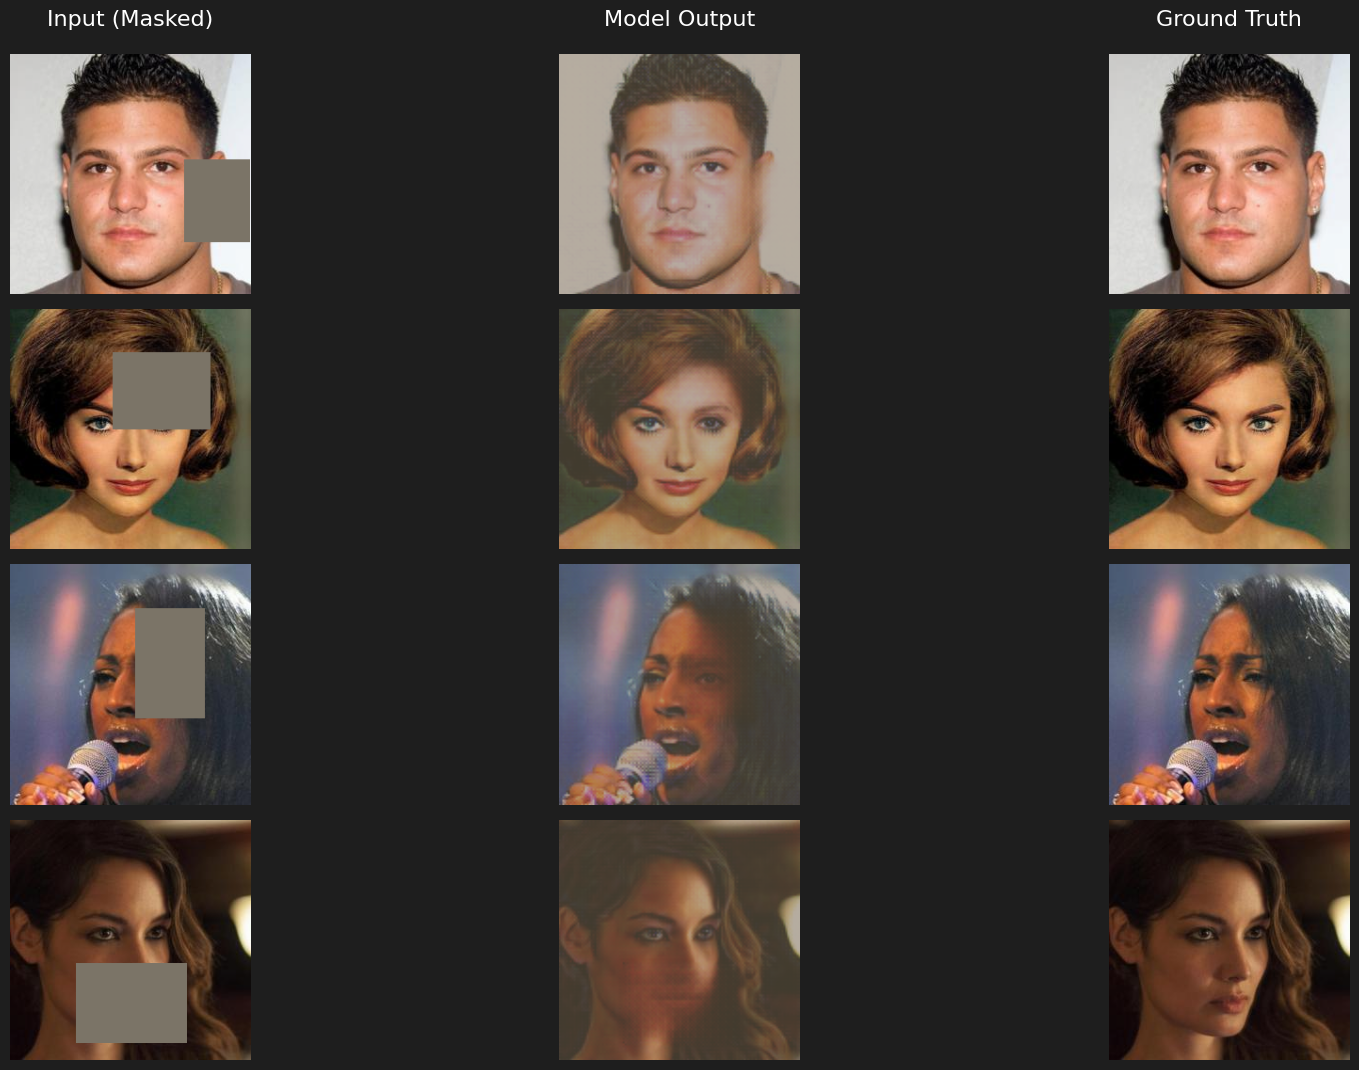

Epoch 2/5: 100%|██████████| 1688/1688 [11:17<00:00,  2.49it/s, loss=0.937]


Visualizing Epoch 2...


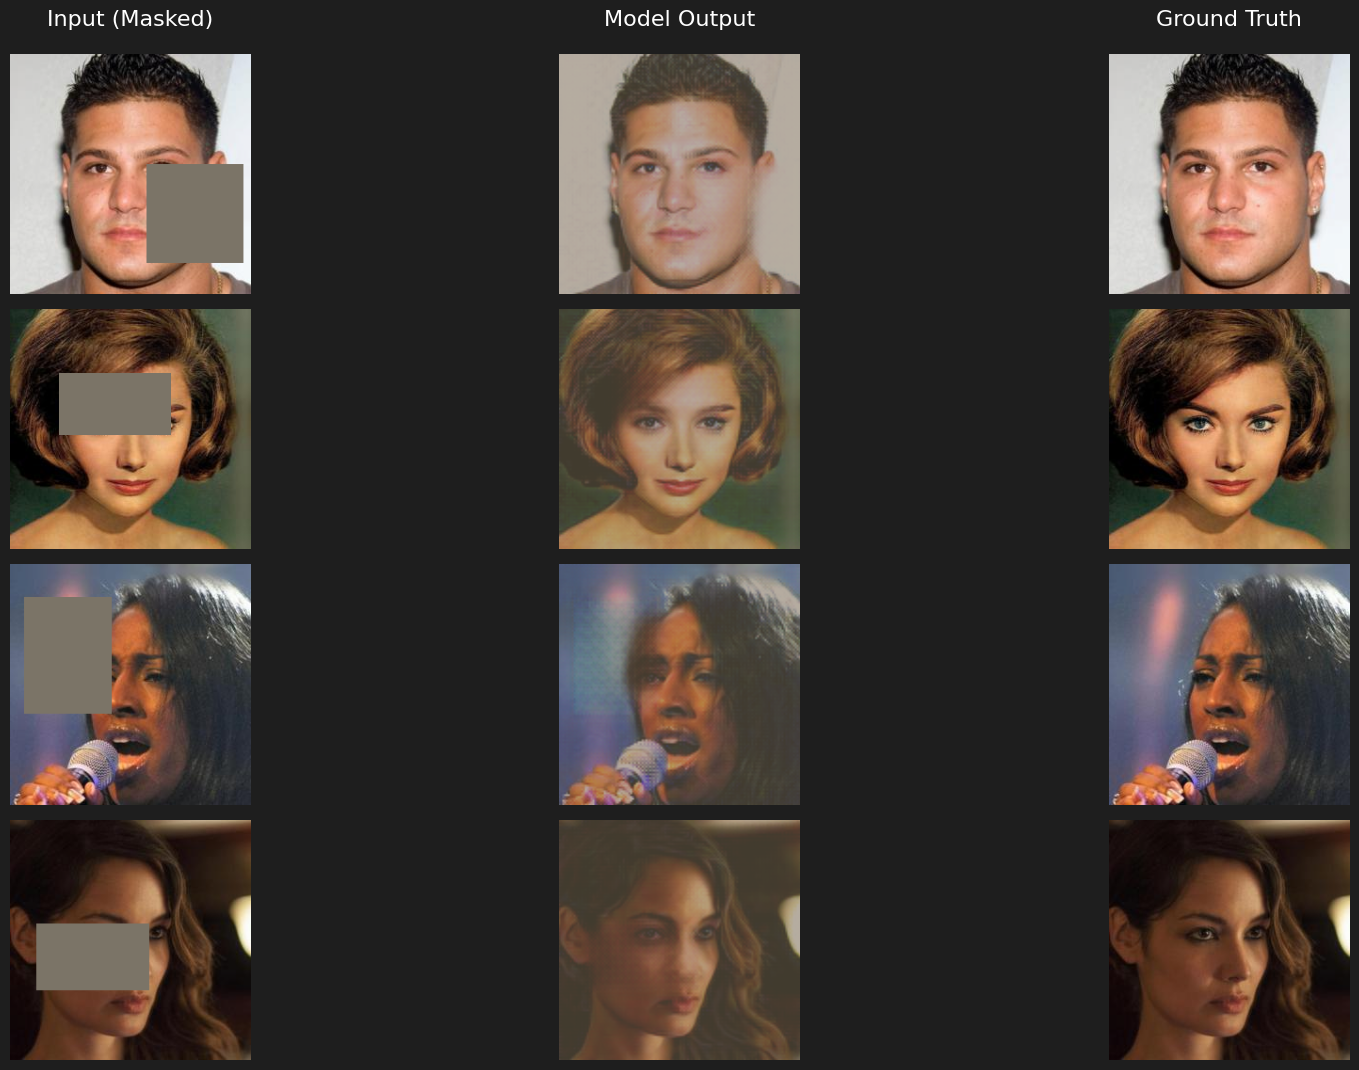

Epoch 3/5: 100%|██████████| 1688/1688 [11:23<00:00,  2.47it/s, loss=0.992]


Visualizing Epoch 3...


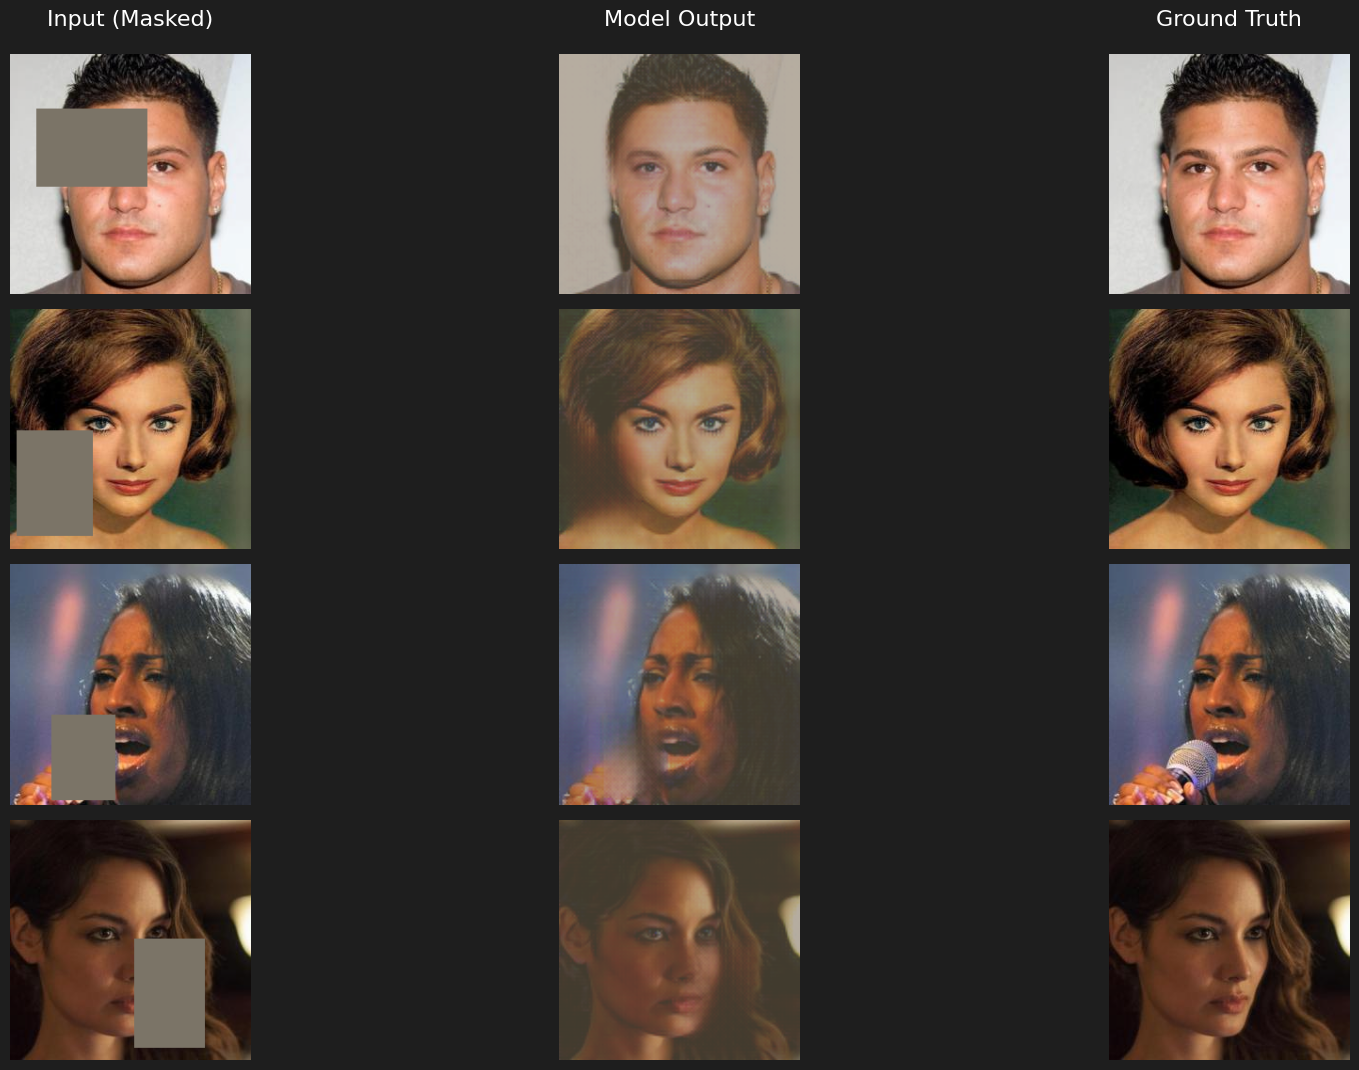

Epoch 4/5: 100%|██████████| 1688/1688 [11:25<00:00,  2.46it/s, loss=0.868]


Visualizing Epoch 4...


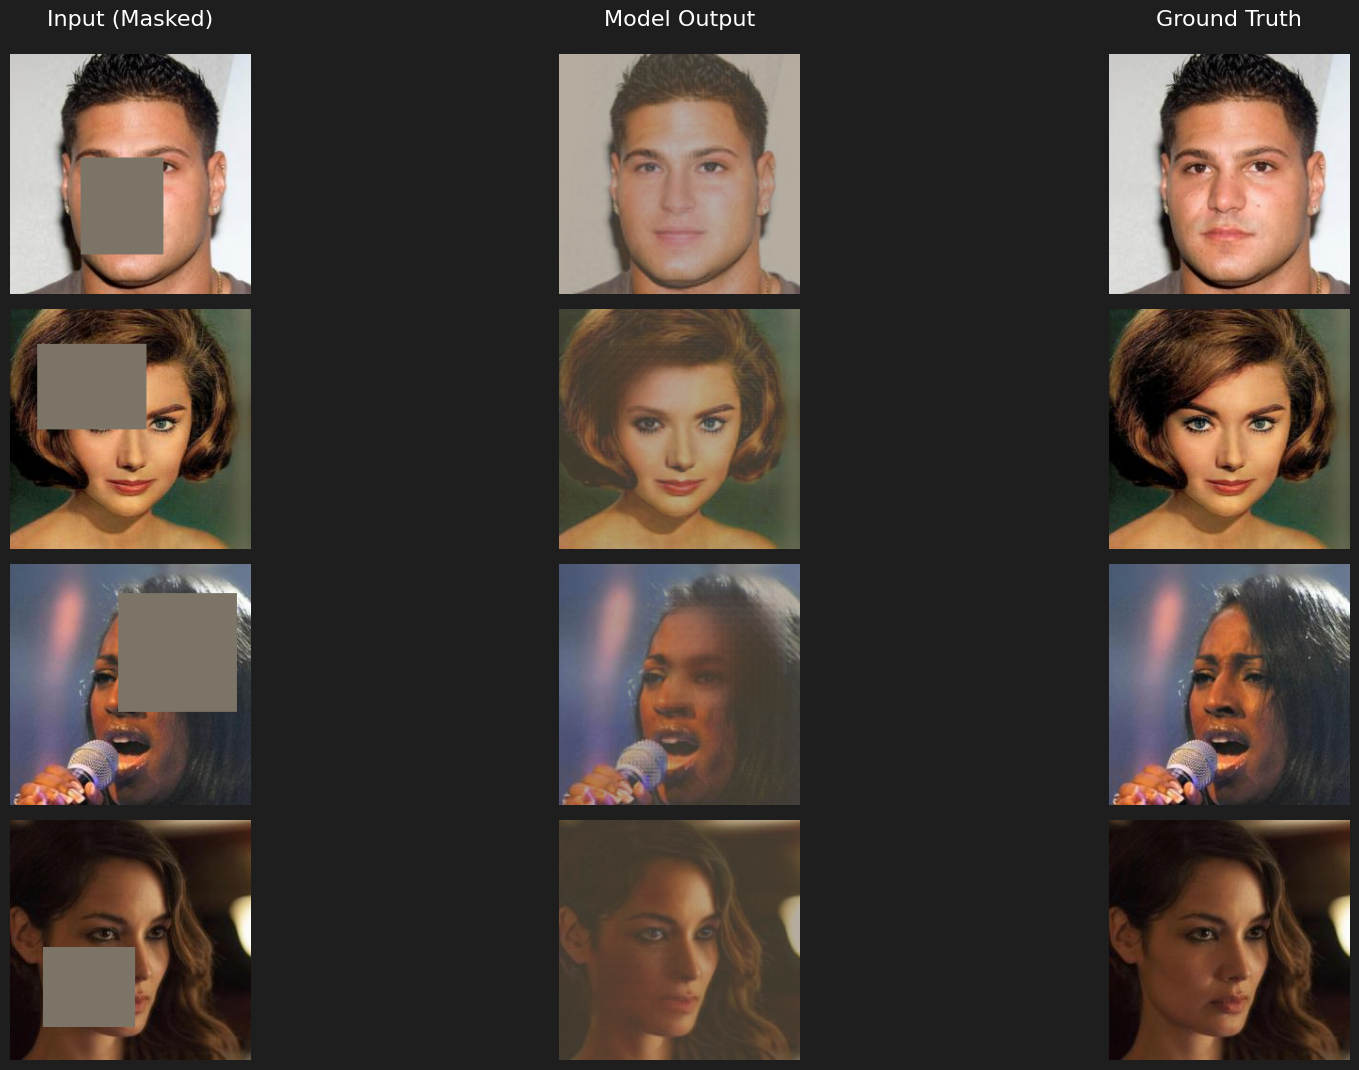

Epoch 5/5: 100%|██████████| 1688/1688 [11:24<00:00,  2.46it/s, loss=0.876]


Visualizing Epoch 5...


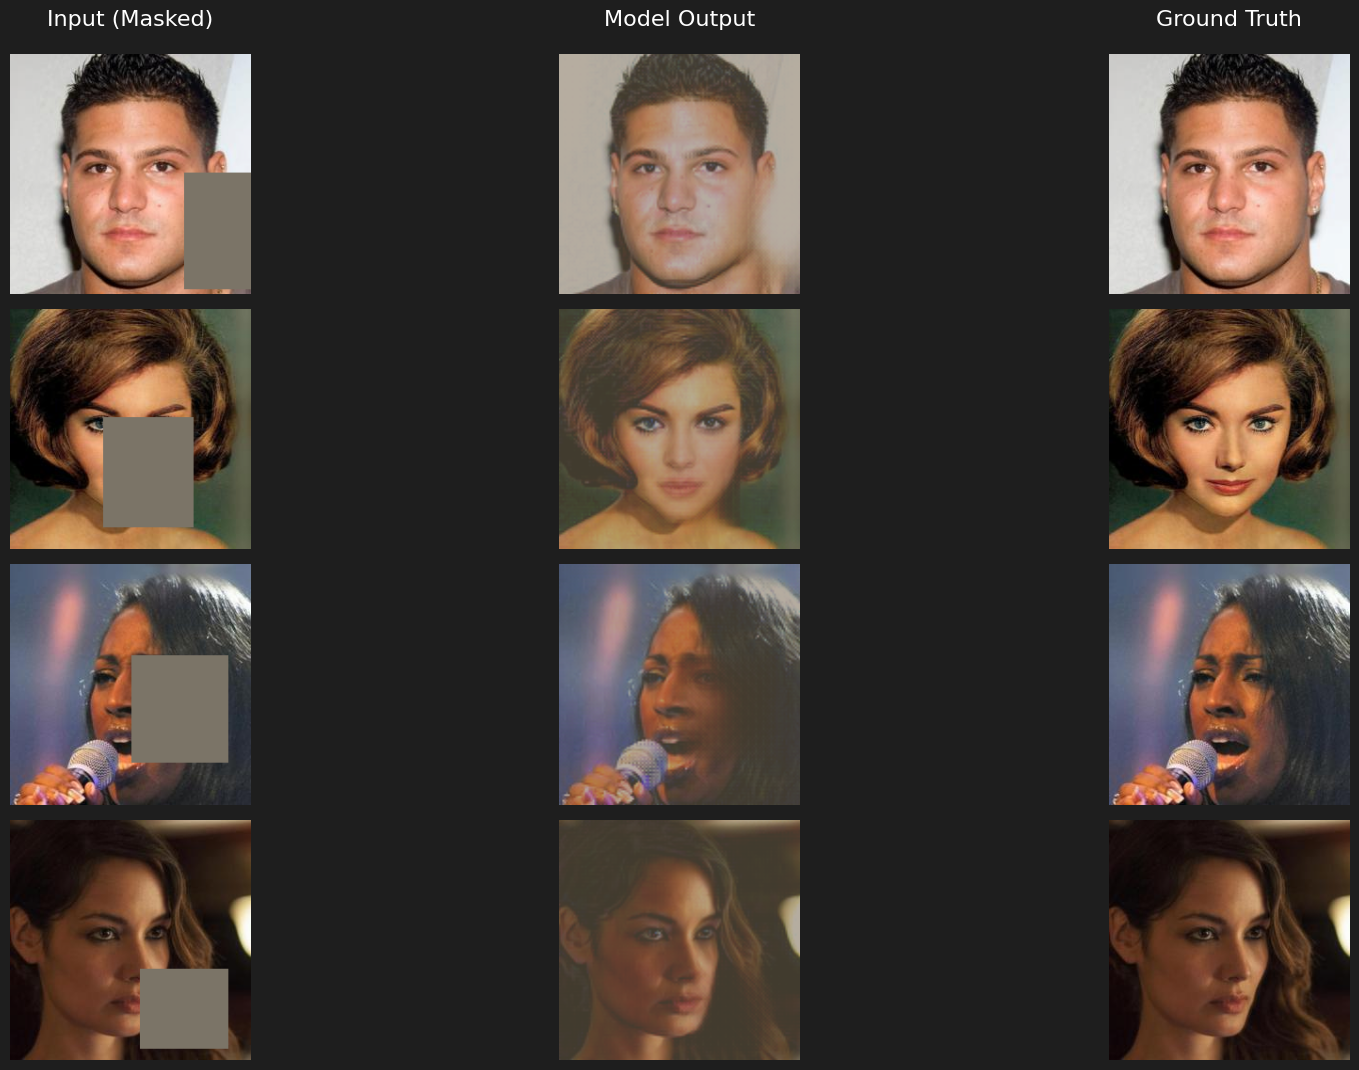

In [15]:
# --- 4. PRE-TRAINED MODEL ARCHITECTURE (ResNet-UNet) ---

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()

        # 1. Load Pre-trained ResNet34 as Encoder
        # We grab the weights so the model isn't "stupid" at the start
        resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        self.base_layers = list(resnet.children())

        # Encoder Layers (Extracting features at different scales)
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # Size: Input
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # Size: /2
        self.layer2 = self.base_layers[5]  # Size: /4
        self.layer3 = self.base_layers[6]  # Size: /8
        self.layer4 = self.base_layers[7]  # Size: /16

        # Decoder Layers (Upsampling)
        self.up4 = self.up_block(512, 256)
        self.up3 = self.up_block(256+256, 128) # +256 comes from skip connection
        self.up2 = self.up_block(128+128, 64)
        self.up1 = self.up_block(64+64, 64)

        # Final output
        self.last_conv = nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1),
            nn.Tanh() # Tanh forces output between [-1, 1], matching our normalization
        )

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x, mask=None):
        # We don't strictly need the mask input for ResNet, but keeping signature consistent

        # Encoder
        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        # Decoder with Skip Connections
        upsample4 = self.up4(layer4)
        cat4 = torch.cat([upsample4, layer3], dim=1)

        upsample3 = self.up3(cat4)
        cat3 = torch.cat([upsample3, layer2], dim=1)

        upsample2 = self.up2(cat3)
        cat2 = torch.cat([upsample2, layer1], dim=1)

        upsample1 = self.up1(cat2)

        # We resize layer0 to match upsample1 if dimensions differ slightly due to padding
        if layer0.shape != upsample1.shape:
             layer0 = transforms.functional.resize(layer0, size=upsample1.shape[2:])

        # Add Skip connection from very first layer? (Optional, skipping here for simplicity)

        out = self.last_conv(upsample1)

        # Resize to original input size (256x256) to be safe
        out = nn.functional.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)
        return out

# --- 5. PERCEPTUAL LOSS (The Anti-Blur Fix) ---

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Use VGG16 to extract features (frozen, not training)
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()

        for x in range(4):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg[x])

        # Freeze VGG parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        # Get features from both images
        h_pred = self.slice1(pred)
        h_target = self.slice1(target)
        loss1 = torch.mean((h_pred - h_target) ** 2)

        h_pred = self.slice2(h_pred)
        h_target = self.slice2(h_target)
        loss2 = torch.mean((h_pred - h_target) ** 2)

        h_pred = self.slice3(h_pred)
        h_target = self.slice3(h_target)
        loss3 = torch.mean((h_pred - h_target) ** 2)

        return loss1 + loss2 + loss3

# --- 6. TRAINING LOOP ---

def train_pretrained_model():
    print("Initializing ResNet-UNet...")
    model = ResNetUNet().to(DEVICE)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0002) # Lower LR for fine-tuning

    # Losses
    criterion_pixel = nn.L1Loss() # Sharpness
    criterion_perceptual = PerceptualLoss().to(DEVICE) # Texture/Structure

    epochs = 5 # Increase this for real results

    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for masked_img, mask, original_img in loop:
            masked_img = masked_img.to(DEVICE)
            original_img = original_img.to(DEVICE)

            optimizer.zero_grad()

            # Forward
            prediction = model(masked_img)

            # Loss Calculation
            # 1. Pixel Loss (L1) matches colors
            l1_loss = criterion_pixel(prediction, original_img)
            # 2. Perceptual Loss matches textures (The "VGG Loss")
            vgg_loss = criterion_perceptual(prediction, original_img)

            # Combined Loss (Weight VGG higher for better texture)
            total_loss = l1_loss + (0.1 * vgg_loss)

            total_loss.backward()
            optimizer.step()

            loop.set_postfix(loss=total_loss.item())

        # Visualize after every epoch
        print(f"Visualizing Epoch {epoch+1}...")
        visualize_1080p(model, test_loader, DEVICE)

    return model

# Run the training
model = train_pretrained_model()

In [15]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

class InpaintingPostProcessor:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def tensor_to_uint8(self, tensor):
        """
        Converts a normalized PyTorch tensor (C, H, W) to a standard image (H, W, C)
        in uint8 format [0-255] for OpenCV.
        """
        # 1. Move to CPU and detach
        t = tensor.clone().detach().cpu()

        # 2. Denormalize (Input = (x - mean) / std  ->  Output = x * std + mean)
        for t_c, m, s in zip(t, self.mean, self.std):
            t_c.mul_(s).add_(m)

        # 3. Clamp to [0, 1] and Permute to (H, W, C)
        t = torch.clamp(t, 0, 1)
        t = t.permute(1, 2, 0).numpy()

        # 4. Convert to [0, 255] uint8
        return (t * 255).astype(np.uint8)

    def poisson_blend(self, original, generated, mask):
        """
        Applies OpenCV Seamless Cloning (Poisson Blending).

        Args:
            original: The ground truth or masked input image (uint8)
            generated: The model's raw output (uint8)
            mask: The mask tensor (0=hole, 1=valid)
        """
        # Convert mask to uint8 for OpenCV
        # We need the mask to be 255 where the HOLE is.
        # Current mask: 0=Hole, 1=Valid. So we invert it.
        mask_np = mask.clone().detach().cpu().squeeze().numpy() # (H, W)
        binary_mask = ((1 - mask_np) * 255).astype(np.uint8)

        # Dialate mask slightly to ensure we cover the seam
        kernel = np.ones((5, 5), np.uint8)
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

        # Center of the image
        center = (original.shape[1] // 2, original.shape[0] // 2)

        try:
            # NORMAL_CLONE mixes gradients of source and destination
            # This makes the lighting of the generated patch match the original image
            seamless = cv2.seamlessClone(generated, original, dilated_mask, center, cv2.NORMAL_CLONE)
            return seamless
        except Exception as e:
            # Fallback if cv2 fails (rare, usually due to mask size)
            print(f"Blending failed: {e}. Returning composite.")
            return self.naive_composite(original, generated, mask_np)

    def naive_composite(self, original, generated, mask_np):
        """
        Simple copy-paste: Keep original pixels where valid, use generated where hole.
        Does NOT fix lighting seams.
        """
        # Expand mask to 3 channels
        mask_3ch = np.stack([mask_np]*3, axis=-1)

        # Formula: (Original * Mask) + (Generated * (1 - Mask))
        # Mask is 1 for Valid, 0 for Hole
        composite = (original * mask_3ch) + (generated * (1 - mask_3ch))
        return composite.astype(np.uint8)

    def process_batch(self, model, masked_img, mask, ground_truth):
        """
        Runs inference and post-processing on a single item.
        """
        model.eval()
        with torch.no_grad():
            # Add batch dimension if missing
            if masked_img.dim() == 3:
                masked_img = masked_img.unsqueeze(0)
                mask = mask.unsqueeze(0)

            # 1. Inference
            prediction = model(masked_img)

            # Take first item in batch
            pred_uint8 = self.tensor_to_uint8(prediction[0])
            orig_uint8 = self.tensor_to_uint8(ground_truth[0])
            masked_input_uint8 = self.tensor_to_uint8(masked_img[0])

            # 2. Naive Composite (Copy-Paste)
            # Use mask[0] because we need (1, H, W) -> (H, W)
            mask_single = mask[0].cpu().numpy().squeeze()
            naive_result = self.naive_composite(orig_uint8, pred_uint8, mask_single)

            # 3. Poisson Blending (Seamless)
            # Note: We pass orig_uint8 as destination, pred_uint8 as source
            # The mask tells OpenCV which part of 'source' to blend into 'destination'
            blended_result = self.poisson_blend(orig_uint8, pred_uint8, mask[0])

            return masked_input_uint8, pred_uint8, naive_result, blended_result

# --- USAGE EXAMPLE ---

def visualize_post_processing(model, dataset_loader):
    # Initialize processor with your dataset's mean/std
    # Note: Ensure these match the ones used in your transform!
    processor = InpaintingPostProcessor(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # Get a batch
    masked_img, mask, ground_truth = next(iter(dataset_loader))
    masked_img, mask, ground_truth = masked_img.to(DEVICE), mask.to(DEVICE), ground_truth.to(DEVICE)

    # Process
    masked_vis, raw_out, naive_out, blended_out = processor.process_batch(
        model, masked_img, mask, ground_truth
    )

    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["Masked Input", "Raw Model Output", "Naive Composite", "Poisson Blended (Final)"]
    images = [masked_vis, raw_out, naive_out, blended_out]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.axis('off')

        # Highlight the seam issue in Naive Composite
        if title == "Naive Composite":
            ax.text(10, 240, "Visible Seams", color='red', fontsize=12, fontweight='bold')
        if title == "Poisson Blended (Final)":
            ax.text(10, 240, "Seamless", color='lime', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run it
visualize_post_processing(model, test_loader)